In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
# Casey region crop (Budd Coast sector, Wilkes Land, East Antarctica)
x_min = 1_700_000
x_max = 2_700_000
y_min = - 1_400_000
y_max = - 400_000

REDO_BEDMAP_CROP = False

if REDO_BEDMAP_CROP:
    # 82 M data points
    bedmap123 = pd.read_csv("/home/kim/data/bedmap_raw_data/bedmap123.csv")
    # Crop to the region of interest: HERE ~ 4 M subset
    bedmap123_casey = bedmap123[
        (bedmap123["x"] > x_min) & (bedmap123["x"] < x_max) & (bedmap123["y"] > y_min) & (bedmap123["y"] < y_max)]
    # Save 
    bedmap123_casey.to_csv("/home/kim/data/bedmap_raw_data/bedmap123_casey.csv", index = False)

else: 
    # Just load
    bedmap123_casey = pd.read_csv("/home/kim/data/bedmap_raw_data/bedmap123_casey.csv")

(21643, 9)


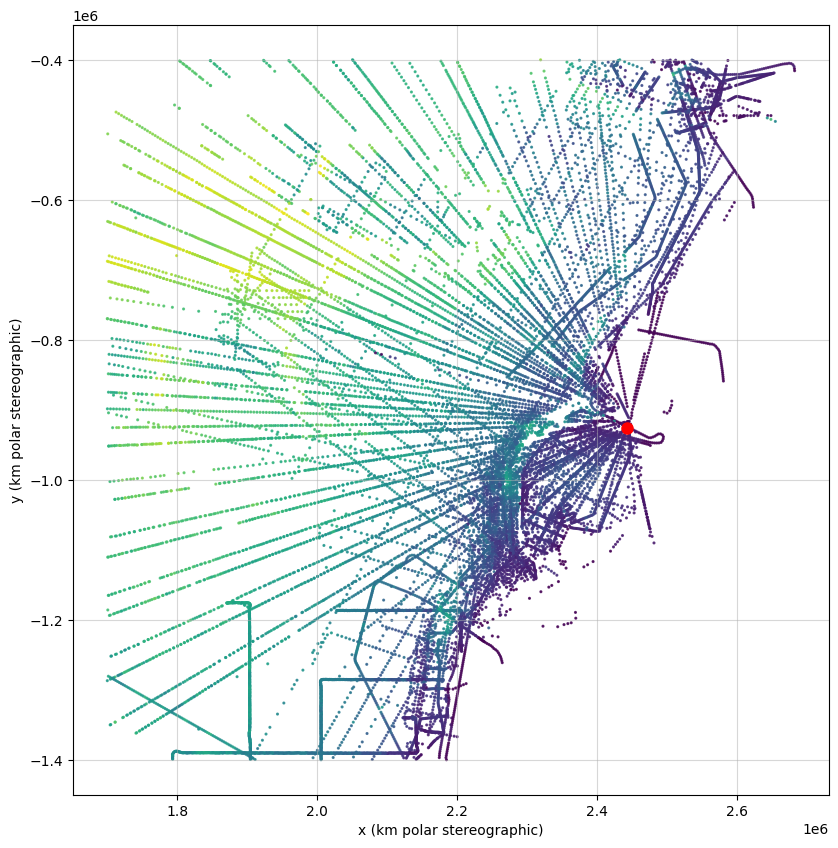

In [3]:
SUBSAMPLE_RATE = 200
# subsample to reduce number of data points
bedmap123_casey_ss = bedmap123_casey[::SUBSAMPLE_RATE]
print(bedmap123_casey_ss.shape)

# Define skiway coordinates
skiway_y = - 926_321.561224
skiway_x = 2_442_514.460804

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    bedmap123_casey_ss['x'], 
    bedmap123_casey_ss['y'], 
    c = bedmap123_casey_ss['t'], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

ax.plot(skiway_x, skiway_y, "ro", markersize = 8, label = "Casey skiway")

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)  # Show gridlines

# Firn adjustment (applied to all data from the region)

In [4]:
# Load meta data which contains firn adjustment info
meta = pd.read_csv("/home/kim/data/bedmap_raw_data_test/bedmap123_metadata.csv")

# Extract float
meta["firn_correction"] = meta.firn.str.extract(r"([-+]?\d*\.?\d+)").astype(float)
# Replace -9999 with 0.0 (We assume this means "zero" adjustment applied so far.)
meta["firn_correction"] = meta["firn_correction"].replace(-9999, 0.0)
# Calculate remaining delta (we correct all data to have a firn correction of 10)
# t_corrected = t_observed - 10

UNIVERSAL_FIRN_CORRECTION = 10.0
meta["firn_correction_delta"] = meta["firn_correction"] - UNIVERSAL_FIRN_CORRECTION

# Create lookup dictionary from meta
firn_delta_lookup = dict(zip(meta["source"], meta["firn_correction_delta"]))

# Add the correction delta to the thickness points
# NOTE: Create fa (firn adjusted) variable
bedmap123_casey["t_fa"] = (
    bedmap123_casey["t"] + bedmap123_casey["source"].map(firn_delta_lookup)
)

# Normalise input coordinates

In [15]:
bedmap123_casey["x_norm"] = (bedmap123_casey["x"] - x_min) / (x_max - x_min)
bedmap123_casey["y_norm"] = (bedmap123_casey["y"] - y_min) / (y_max - y_min)

In [18]:
skiway_x_norm = (skiway_x - x_min) / (x_max - x_min)
skiway_y_norm = (skiway_y - y_min) / (y_max - y_min)

print(skiway_x_norm, skiway_y_norm)

0.7425144608040001 0.4736784387760001


In [16]:
bedmap123_casey

,lon,lat,x,y,s,t,b,b_inferred,source,t_fa,x_norm,y_norm
0,124.890800,-71.082500,1.700822e+06,-1.186104e+06,2850.00,3121.00,-271.00,False,BEDMAP1_1966-2000_AIR_BM1.csv,3111.00,0.000822,0.213896
1,126.088500,-70.719300,1.708414e+06,-1.245272e+06,2770.00,2179.00,591.00,False,BEDMAP1_1966-2000_AIR_BM1.csv,2169.00,0.008414,0.154728
2,126.334300,-70.669010,1.707581e+06,-1.255917e+06,2789.00,3078.00,-289.00,False,BEDMAP1_1966-2000_AIR_BM1.csv,3068.00,0.007581,0.144083
3,126.726700,-70.577800,1.707105e+06,-1.273674e+06,2740.00,2630.00,110.00,False,BEDMAP1_1966-2000_AIR_BM1.csv,2620.00,0.007105,0.126326
4,126.804300,-70.559200,1.707042e+06,-1.277230e+06,2713.00,2579.00,134.00,False,BEDMAP1_1966-2000_AIR_BM1.csv,2569.00,0.007042,0.122770
...,...,...,...,...,...,...,...,...,...,...,...,...
4328583,110.096767,-70.626062,1.995151e+06,-7.299938e+05,2613.59,3553.37,-939.78,False,UTIG_2010_ICECAP_AIR_BM3.csv,3543.37,0.295151,0.670006
4328584,110.096546,-70.625845,1.995176e+06,-7.299945e+05,2614.65,3554.26,-939.61,False,UTIG_2010_ICECAP_AIR_BM3.csv,3544.26,0.295176,0.670006
4328585,110.096322,-70.625623,1.995202e+06,-7.299952e+05,2615.06,3559.66,-944.60,False,UTIG_2010_ICECAP_AIR_BM3.csv,3549.66,0.295202,0.670005
4328586,110.095882,-70.625189,1.995254e+06,-7.299965e+05,2613.83,3561.64,-947.81,False,UTIG_2010_ICECAP_AIR_BM3.csv,3551.64,0.295254,0.670003


In [17]:
ice_thickness_points_casey = torch.tensor(bedmap123_casey[["x_norm", "y_norm", "t_fa"]].values).float()
print(ice_thickness_points_casey.shape)

torch.save(ice_thickness_points_casey, "data/ice_thickness_points_casey.pt")

torch.Size([4328588, 3])
